# Plot the decision surfaces of ensembles of trees on the iris dataset
- 의사 결정 트리 분류기, 랜덤 포레스트 분류기, 엑스트라 트리 분류기, AdaBoost 분류기에 의해 학습된 결정 경계를 비교한다.

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8666666666666667
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933333333333333


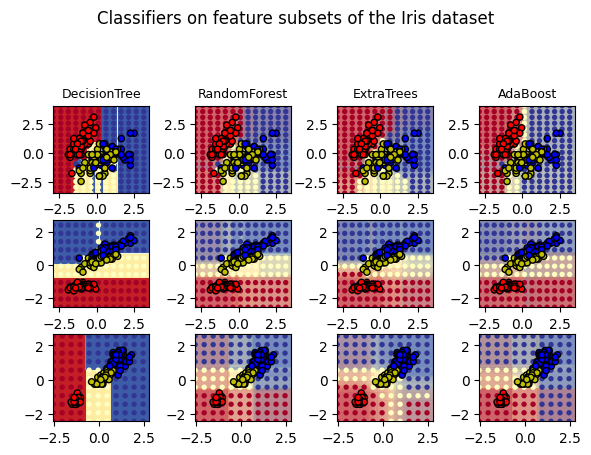

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.tree import DecisionTreeClassifier

# 파라미터들
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # 결정 표면 등고선을 그릴 때 사용되는 간격
plot_step_coarser = 0.5  # 거친 분류기 예측을 위한 단계 폭
RANDOM_SEED = 13  # 각 반복마다 시드를 수정한다.

# 데이터 로드
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators),
]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # 2개의 상응하는 특징만 갖는다
        X = iris.data[:, pair]
        y = iris.target

        # 셔플
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # 표준화
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # 학습
        model.fit(X, y)

        scores = model.score(X, y)
        # str() 함수를 사용하여 각 열과 콘솔에 대한 제목을 생성하고, 문자열의 불필요한 부분을 잘라내는 방법
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # 각 column의 위에 제목 달기
            plt.title(model_title, fontsize=9)

        # 세밀한 격자를 입력으로 사용하여 결정 경계를 시각화하기 위해 채워진 등고선 플로을 사용하여 결정 경계를 그린다.
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # 하나의 DecisionTreeClassifier를 그래프로 그리거나, 분류기 앙상블의 결정 경계를 알파 블렌딩하여 그리기
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # 사용 중인 추정기의 수에 따라 알파 블렌딩 레벨을 선택
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # 결정 경게와는 다른 앙상블 분류 결과르 ㄹ보여주기 위해 더 거친 격자를 구축하여 그래프로 표시.
        # 이 포인트들은 규칙적으로 공간이 배치되어 이씅며 검은 윤곽이 없어야 한다.
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )

        # 훈련 데이터 포인트를 그래프로 그리기.
        # 이들은 군집화 되어 있으며 검은 윤곽선이 있어야 한다.
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # 흐름에 따라 다음 플롯으로 넘어가야 한다.

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()